In [1]:
import pandas as pd
import jieba as jb
from torch.utils.data import DataLoader
import re
import torch
import torch.nn as nn
import myModel
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import time
from torchtext.data.functional import to_map_style_dataset
import matplotlib.pyplot as plt

E:\anaconda\envs\Pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

df_train = pd.read_csv(r'data/train_data.csv')
df_test = pd.read_csv(r'data/test_data.csv')

moods = {0: '喜悦', 1: '愤怒', 2: '厌恶', 3: '低落'}

# 定义删除除字母,数字，汉字以外的所有符号的函数
def remove_punctuation(line):
    line = str(line)
    if line.strip() == '':
        return ''
    rule = re.compile(u"[^a-zA-Z0-9\u4E00-\u9FA5]")
    line = rule.sub('', line)
    return line

def stopwordslist(filepath):
    stopwords = [line.strip() for line in open(filepath, 'r', encoding='utf-8').readlines()]
    return stopwords

# 加载停用词
stopwords = stopwordslist("data/cn_stopwords.txt")

df_train['clean_review'] = df_train['review'].apply(remove_punctuation)
df_test['clean_review'] = df_test['review'].apply(remove_punctuation)
print(df_train[['clean_review', 'label']].head())

                                        clean_review  label
0  回复去果度做咩啊努力存錢去埃塞俄比亞買咖啡埼沂撬嫡娴我决定不买房不买车更不买爱峰我要努力存钱...      0
1  金价升至1261美元创历史新高北京时间6月18日晚间消息周五纽约金价攀升并创造历史新高目前上...      0
2                           哟这妞是新品吗我要了众多新品上架Vilaaaaa      1
3  还有一天之内中国日喀则地区定日县发生50级地震智利88级地震相当于120多个73级海地地震而...      2
4          要记住未来由你来创造如果你不参与那么别人就会为你打造未来最好的办法就是今天你投票吧      0


In [3]:
df_train['cut_review'] = df_train['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
df_test['cut_review'] = df_test['clean_review'].apply(lambda x: " ".join([w for w in list(jb.cut(x)) if w not in stopwords]))
print(df_train[['cut_review', 'label']].head())

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\32075\AppData\Local\Temp\jieba.cache
Loading model cost 0.479 seconds.
Prefix dict has been built successfully.


                                          cut_review  label
0  回复 果度 做 咩 努力 存錢 埃塞 俄比亞 買 咖啡 埼 沂 撬 嫡 娴 决定 买房 买车...      0
1  金价 升至 1261 美元 创 历史 新高 北京 时间 月 18 日 晚间 消息 周五 纽约...      0
2                             妞 新品 众多 新品 上架 Vilaaaaa      1
3  一天 之内 中国 日喀则地区 定日县 发生 50 级 地震 智利 88 级 地震 相当于 1...      2
4                    记住 未来 创造 参与 会 打造 未来 最好 办法 今天 投票      0


In [4]:
# 使用空格分词器
tokenizer = get_tokenizer('basic_english')

# 迭代器是一次性用品
train_iter = iter(df_train[['cut_review', 'label']].values)


def yield_tokens(data_iter):
    for text, _ in data_iter:
        yield tokenizer(text)


vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])  # 设置默认索引，如果找不到单词，则会选择默认索引

In [5]:
vocab(['不錯', '妳', '別', '圓圓', '拖下水', '明明', '暧昧', '刚才', '说', '何韵诗', '爱', '听', '阿诗', '今天',
             '玩儿'])

[11145,
 2750,
 13992,
 89947,
 71679,
 960,
 3846,
 454,
 1,
 27693,
 11,
 91,
 84846,
 7,
 3231]

In [6]:
label_name = list(set(df_train['label'].values))
label_name

[0, 1, 2, 3]

In [7]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: label_name.index(x)

In [8]:
text_pipeline('甜蜜 时间 会 亲亲 最近 工作 太忙 白天 晚上 没有 时间 已经 很久没 某人')
moods[label_pipeline(3)]

'低落'

In [9]:
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]

    for (_text, _label) in batch:
        # 标签列表
        label_list.append(label_pipeline(_label))

        # 文本列表
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)

        # 偏移量，即语句的总词汇量
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    text_list = torch.cat(text_list)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)  # 返回维度dim中输入元素的累计和

    return text_list.to(device), label_list.to(device), offsets.to(device)

In [10]:
num_class = len(label_name)
vocab_size = len(vocab)
em_size = 64
hidden_dim = 128
filter_sizes = [3, 4, 5]  # 卷积核大小列表
num_filters = 100

In [11]:
EPOCHS = 15  # epoch
LR = 0.001  # 学习率
BATCH_SIZE = 64  # batch size for training

In [12]:
# 构建数据集
train_iter = iter(df_train[['cut_review', 'label']].values)
test_iter = iter(df_test[['cut_review', 'label']].values)
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)

valid_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                              shuffle=True, collate_fn=collate_batch)


def train(dataloader):
    model.train()  # 切换为训练模式
    total_acc, train_loss, total_count = 0, 0, 0
    log_interval = 1000
    start_time = time.time()

    for idx, (text, label, offsets) in enumerate(dataloader):

        predicted_label = model(text, offsets)

        optimizer.zero_grad()  # grad属性归零
        loss = criterion(predicted_label, label)  # 计算网络输出和真实值之间的差距，label为真实值
        loss.backward()  # 反向传播
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)  # 梯度裁剪
        optimizer.step()  # 每一步自动更新

        # 记录acc与loss
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        train_loss += loss.item()
        total_count += label.size(0)

        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print('| epoch {:1d} | {:4d}/{:4d} batches '
                  '| train_acc {:4.3f} train_loss {:4.5f}'.format(epoch, idx, len(dataloader),
                                                                  total_acc / total_count, train_loss / total_count))
            total_acc, train_loss, total_count = 0, 0, 0
            start_time = time.time()


def evaluate(dataloader):
    model.eval()  # 切换为测试模式
    total_acc, train_loss, total_count = 0, 0, 0

    with torch.no_grad():
        for idx, (text, label, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)

            loss = criterion(predicted_label, label)  # 计算loss值
            # 记录测试数据
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            train_loss += loss.item()
            total_count += label.size(0)

    return total_acc / total_count, train_loss / total_count

In [13]:
model_name = ['FC', 'LSTM', 'RNN', 'CNN', 'Transformer']
model_list = [myModel.TextClassificationModel(vocab_size, em_size, num_class).to(device),
              myModel.LSTMClassificationModel(vocab_size, em_size, hidden_dim, num_class).to(device),
              myModel.RNNTextClassifier(vocab_size, em_size, hidden_dim, num_class).to(device),
              myModel.CNNTextClassifier(vocab_size, em_size, filter_sizes, num_filters, num_class).to(device),
              myModel.TransformerClassifier(vocab_size, em_size, 8, 4, num_class).to(device)]


model_index = 0
All_Loss = []
All_Acc = []
for model in model_list:
    Losses = []
    Acc = []
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    total_accu = None

    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        train(train_dataloader)
        val_acc, val_loss = evaluate(valid_dataloader)

        # 获取当前的学习率
        lr = optimizer.state_dict()['param_groups'][0]['lr']

        if total_accu is not None and total_accu > val_acc:
            scheduler.step()
        else:
            total_accu = val_acc
        print('-' * 69)
        print('| epoch {:1d} | time: {:4.2f}s | '
              'valid_acc {:4.3f} valid_loss {:4.3f} '
              '| lr {:4.6f},  model_name = {}'.format(epoch,
                                                      time.time() - epoch_start_time,
                                                      val_acc, val_loss, lr,
                                                      model_name[model_index]))
        print('-' * 69)
        Losses.append(val_loss)
        Acc.append(val_acc)
    model_index += 1
    All_Loss.append(Losses)
    All_Acc.append(Acc)

| epoch 1 | 1000/5088 batches | train_acc 0.538 train_loss 0.01801
| epoch 1 | 2000/5088 batches | train_acc 0.573 train_loss 0.01659
| epoch 1 | 3000/5088 batches | train_acc 0.581 train_loss 0.01615
| epoch 1 | 4000/5088 batches | train_acc 0.598 train_loss 0.01571
| epoch 1 | 5000/5088 batches | train_acc 0.601 train_loss 0.01559
---------------------------------------------------------------------
| epoch 1 | time: 46.13s | valid_acc 0.606 valid_loss 0.015 | lr 0.001000,  model_name = FC
---------------------------------------------------------------------
| epoch 2 | 1000/5088 batches | train_acc 0.632 train_loss 0.01378
| epoch 2 | 2000/5088 batches | train_acc 0.634 train_loss 0.01372
| epoch 2 | 3000/5088 batches | train_acc 0.638 train_loss 0.01367
| epoch 2 | 4000/5088 batches | train_acc 0.639 train_loss 0.01363
| epoch 2 | 5000/5088 batches | train_acc 0.640 train_loss 0.01357
---------------------------------------------------------------------
| epoch 2 | time: 46.40s | v

| epoch 15 | 5000/5088 batches | train_acc 0.737 train_loss 0.00905
---------------------------------------------------------------------
| epoch 15 | time: 45.94s | valid_acc 0.604 valid_loss 0.016 | lr 0.000000,  model_name = FC
---------------------------------------------------------------------
| epoch 1 | 1000/5088 batches | train_acc 0.561 train_loss 0.01750
| epoch 1 | 2000/5088 batches | train_acc 0.578 train_loss 0.01649
| epoch 1 | 3000/5088 batches | train_acc 0.590 train_loss 0.01609
| epoch 1 | 4000/5088 batches | train_acc 0.594 train_loss 0.01575
| epoch 1 | 5000/5088 batches | train_acc 0.602 train_loss 0.01542
---------------------------------------------------------------------
| epoch 1 | time: 50.84s | valid_acc 0.606 valid_loss 0.015 | lr 0.001000,  model_name = LSTM
---------------------------------------------------------------------
| epoch 2 | 1000/5088 batches | train_acc 0.643 train_loss 0.01350
| epoch 2 | 2000/5088 batches | train_acc 0.643 train_loss 0.01

| epoch 15 | 1000/5088 batches | train_acc 0.776 train_loss 0.00695
| epoch 15 | 2000/5088 batches | train_acc 0.773 train_loss 0.00707
| epoch 15 | 3000/5088 batches | train_acc 0.776 train_loss 0.00695
| epoch 15 | 4000/5088 batches | train_acc 0.773 train_loss 0.00700
| epoch 15 | 5000/5088 batches | train_acc 0.776 train_loss 0.00686
---------------------------------------------------------------------
| epoch 15 | time: 51.10s | valid_acc 0.607 valid_loss 0.018 | lr 0.000000,  model_name = LSTM
---------------------------------------------------------------------
| epoch 1 | 1000/5088 batches | train_acc 0.549 train_loss 0.01830
| epoch 1 | 2000/5088 batches | train_acc 0.557 train_loss 0.01753
| epoch 1 | 3000/5088 batches | train_acc 0.567 train_loss 0.01698
| epoch 1 | 4000/5088 batches | train_acc 0.573 train_loss 0.01664
| epoch 1 | 5000/5088 batches | train_acc 0.582 train_loss 0.01639
---------------------------------------------------------------------
| epoch 1 | time: 51

| epoch 14 | 5000/5088 batches | train_acc 0.671 train_loss 0.01220
---------------------------------------------------------------------
| epoch 14 | time: 50.53s | valid_acc 0.585 valid_loss 0.016 | lr 0.000000,  model_name = RNN
---------------------------------------------------------------------
| epoch 15 | 1000/5088 batches | train_acc 0.671 train_loss 0.01220
| epoch 15 | 2000/5088 batches | train_acc 0.672 train_loss 0.01211
| epoch 15 | 3000/5088 batches | train_acc 0.674 train_loss 0.01211
| epoch 15 | 4000/5088 batches | train_acc 0.669 train_loss 0.01217
| epoch 15 | 5000/5088 batches | train_acc 0.673 train_loss 0.01211
---------------------------------------------------------------------
| epoch 15 | time: 50.43s | valid_acc 0.582 valid_loss 0.016 | lr 0.000000,  model_name = RNN
---------------------------------------------------------------------
| epoch 1 | 1000/5088 batches | train_acc 0.547 train_loss 0.01825
| epoch 1 | 2000/5088 batches | train_acc 0.559 train_los

| epoch 14 | 1000/5088 batches | train_acc 0.724 train_loss 0.00959
| epoch 14 | 2000/5088 batches | train_acc 0.726 train_loss 0.00950
| epoch 14 | 3000/5088 batches | train_acc 0.727 train_loss 0.00951
| epoch 14 | 4000/5088 batches | train_acc 0.724 train_loss 0.00953
| epoch 14 | 5000/5088 batches | train_acc 0.725 train_loss 0.00951
---------------------------------------------------------------------
| epoch 14 | time: 52.44s | valid_acc 0.602 valid_loss 0.016 | lr 0.000000,  model_name = CNN
---------------------------------------------------------------------
| epoch 15 | 1000/5088 batches | train_acc 0.725 train_loss 0.00953
| epoch 15 | 2000/5088 batches | train_acc 0.727 train_loss 0.00949
| epoch 15 | 3000/5088 batches | train_acc 0.725 train_loss 0.00957
| epoch 15 | 4000/5088 batches | train_acc 0.726 train_loss 0.00948
| epoch 15 | 5000/5088 batches | train_acc 0.723 train_loss 0.00954
---------------------------------------------------------------------
| epoch 15 | tim

| epoch 13 | 3000/5088 batches | train_acc 0.636 train_loss 0.01363
| epoch 13 | 4000/5088 batches | train_acc 0.639 train_loss 0.01358
| epoch 13 | 5000/5088 batches | train_acc 0.635 train_loss 0.01366
---------------------------------------------------------------------
| epoch 13 | time: 85.63s | valid_acc 0.567 valid_loss 0.017 | lr 0.000000,  model_name = Transformer
---------------------------------------------------------------------
| epoch 14 | 1000/5088 batches | train_acc 0.638 train_loss 0.01360
| epoch 14 | 2000/5088 batches | train_acc 0.639 train_loss 0.01354
| epoch 14 | 3000/5088 batches | train_acc 0.637 train_loss 0.01356
| epoch 14 | 4000/5088 batches | train_acc 0.637 train_loss 0.01366
| epoch 14 | 5000/5088 batches | train_acc 0.636 train_loss 0.01361
---------------------------------------------------------------------
| epoch 14 | time: 86.41s | valid_acc 0.566 valid_loss 0.017 | lr 0.000000,  model_name = Transformer
------------------------------------------

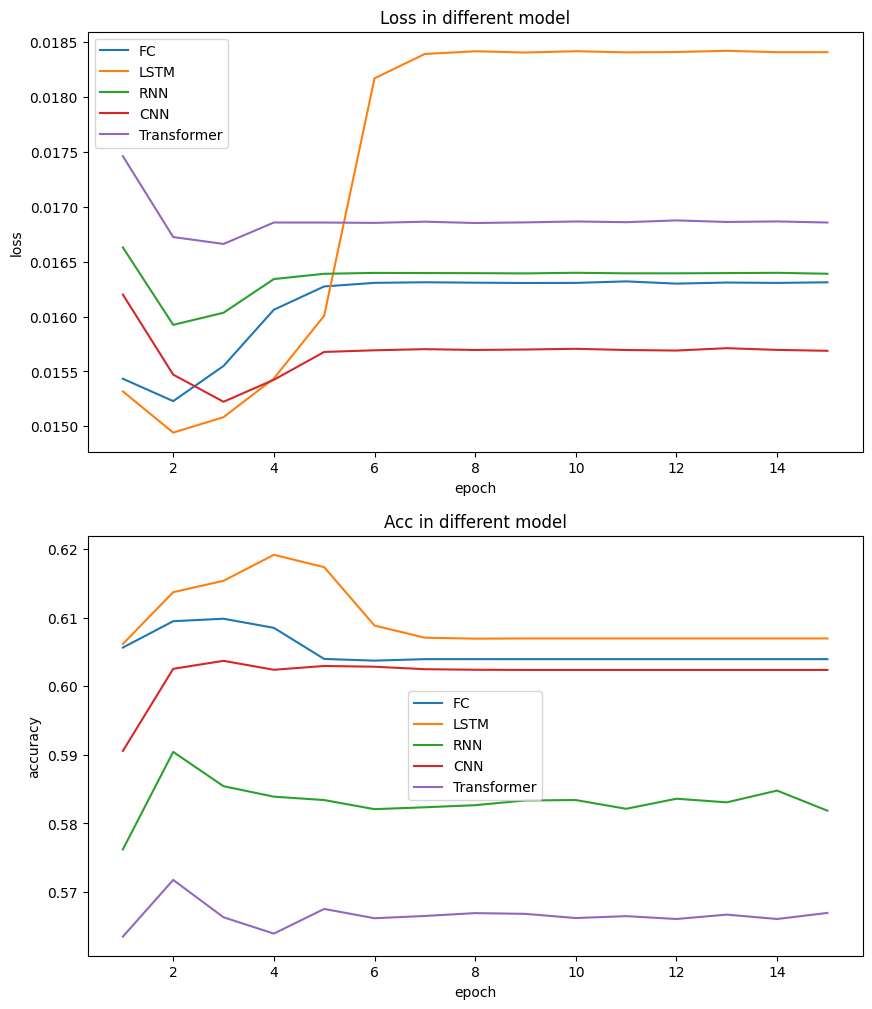

In [14]:
fig = plt.figure(figsize=(10, 12))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)
model_index = 0
for Losses, Acc in zip(All_Loss, All_Acc):    
    ax1.plot(range(1, EPOCHS + 1), Losses, label=model_name[model_index])
    ax1.legend()
    ax2.plot(range(1, EPOCHS + 1), Acc, label=model_name[model_index])
    ax2.legend()
    model_index += 1

ax1.set_title("Loss in different model")
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')

ax2.set_title("Acc in different model")
ax2.set_xlabel('epoch')
ax2.set_ylabel('accuracy')
plt.show()

In [15]:
def predict(text, text_pipeline):
    with torch.no_grad():
        text = torch.tensor(text_pipeline(text))
        output = model(text, torch.tensor([0]))
        return output.argmax(1).item()


model = model.to("cpu")
# 喜悦
# 愤怒
# 厌恶
# 低落
ex_text_str = ['无论发生什么，我都感到喜悦洋溢，仿佛世界都变得明亮起来。',
               '我感到愤怒和愤慨，因为我受到了不公正的对待，我决心要为正义而战。',
               '每当我想起那个令人厌恶的经历，我都会感到恶心和厌烦，希望能忘记它。',
               '心情低落，仿佛一片灰暗笼罩了我的世界，我需要寻找力量来重新振作起来']

for single_text in ex_text_str:
    # ex_text_str = input("输入评价的文本:  ")
    print(single_text)
    single_text = remove_punctuation(single_text)
    single_text = jb.cut(single_text)
    clean_text = ""
    for word in single_text:
        if word not in stopwords:
            clean_text += word
            clean_text += " "

    print("该文本的类别是：%s" % moods[label_name[predict(clean_text, text_pipeline)]])

无论发生什么，我都感到喜悦洋溢，仿佛世界都变得明亮起来。
该文本的类别是：喜悦
我感到愤怒和愤慨，因为我受到了不公正的对待，我决心要为正义而战。
该文本的类别是：喜悦
每当我想起那个令人厌恶的经历，我都会感到恶心和厌烦，希望能忘记它。
该文本的类别是：喜悦
心情低落，仿佛一片灰暗笼罩了我的世界，我需要寻找力量来重新振作起来
该文本的类别是：喜悦
